## import de package

In [5]:
spark
from pyspark.sql import Row
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import pylab as P
import pandas as pd
from operator import add
plt.rcdefaults()
import sys
import re
sys.stdout = open('/dev/stdout', 'w')

## Lecture de l'échantillon de données de wikipedia:

In [10]:
path="/home/herimanitra/Téléchargements/data-master/mapreduce/wikipedia.dat"
mytext = sc.textFile(path)

## Count words (2.82s):

In [21]:
#with removal of special characters:
def clean(x):
    z=re.sub(r"[^\w]"," ",x)
    z=z.split(' ')
    return z
counts = mytext.flatMap(lambda x: clean(x) ).map(lambda x: (x, 1)).reduceByKey(add)
output = counts.collect()
def printMe():
    for (word, count) in output:
        mystr=word.encode('utf-8')
        print ("%s: %i" % (mystr,count) )
%prun printMe()

## Count words dans Hadoop :
real	1m8.466s
user	1m28.748s
sys	0m1.892s


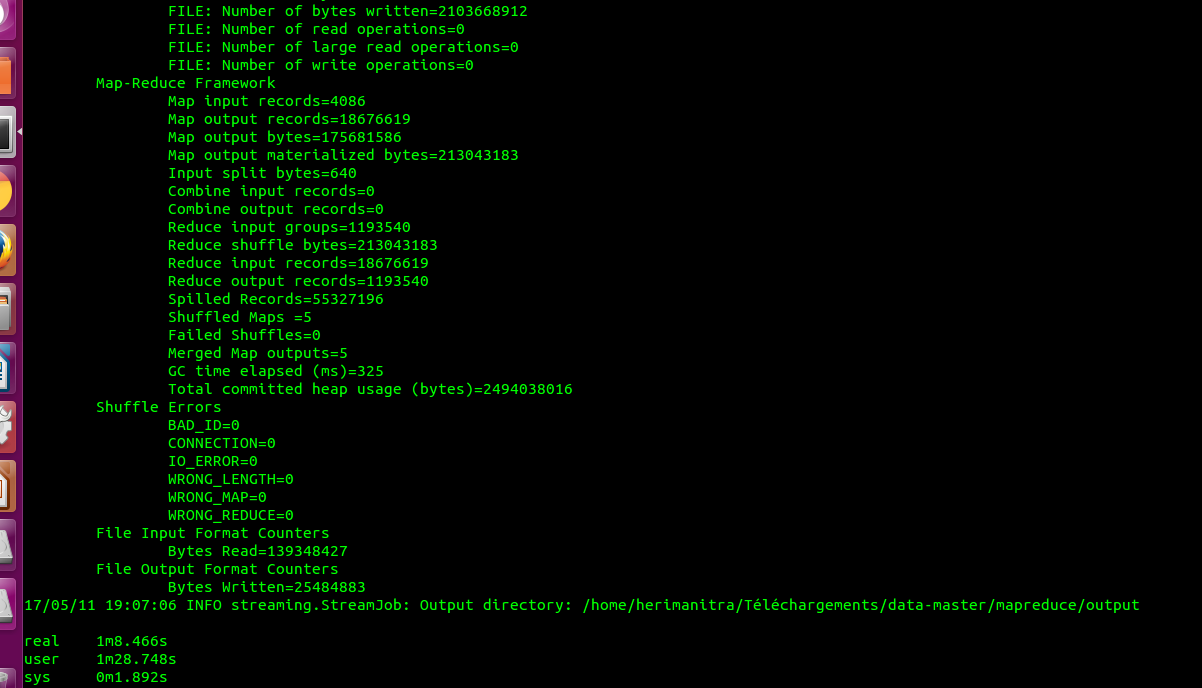

In [24]:
from IPython.display import Image
Image("/media/herimanitra/DONNEES/Cours Uqtr/PIF 6004/hadoopCountWord.png")

#########################################################################################################################

# Exemple plus élaboré avec un comptage du nombre de méthode de programme java:

### Input:
  * Source code java de la fondation Apache entre 2011 - 2016
  
### Output:
  * Extraction des méthodes dans tous les programmes pour quelques logiciels Apache.

### lecture et apercue (2.25s)

In [20]:
def readMySourceCodeWithSpark():
    folder="/home/herimanitra/Téléchargements/data-master/apache20*.csv.gz"
    mydata = spark.read.csv(folder, header=True, inferSchema=True)
    return mydata
%prun  mydata=readMySourceCodeWithSpark()

In [21]:
mydata.select(["content","sample_repo_name","avg_commiter_timestamp","sample_path"]).show()

### schema du fichier de données

In [22]:
mydata.printSchema()

### Combien y-a-t-il de projets logiciels?

In [23]:
projects=mydata.select(["sample_repo_name"]).toPandas()['sample_repo_name'].unique()
print projects

### Sélectionne quelques projets qui nous intéressent:

In [24]:
mydata.where((col('sample_repo_name')=='apache/activemq-artemis') |
             (col('sample_repo_name')=='apache/activemq-openwire') |
             (col('sample_repo_name')=='apache/commons-dbutils') |
             (col('sample_repo_name')=='apache/commons-vfs') |
            (col('sample_repo_name')=='apache/ignite') ).show()

### Nombre de LOC pour une sélection de projets (moins d'1s)

In [25]:
name = 'line'
udf = udf(lambda x: ' '.join(x.split()), StringType())
def LOC_distributed(name,udf):
    X =mydata.where((col('sample_repo_name')=='apache/activemq-artemis') |
                (col('sample_repo_name')=='apache/activemq-openwire') |
                (col('sample_repo_name')=='apache/commons-dbutils') |
                (col('sample_repo_name')=='apache/commons-vfs') |
                (col('sample_repo_name')=='apache/ignite') ).select( *[udf(column).alias(name) if column == name else column for column in ['sample_repo_name','content'] ])
    #split by line:
    X2=X.select(explode(split(col("content"), "pointvirgule")).alias("line"),col("sample_repo_name"))
    return X2.groupBy('sample_repo_name').count()
%prun X4= LOC_distributed(name,udf)

#########################################################################################################################

## Lecture non distribuée avec python et la librairie pandas

In [26]:
def readMySourceCode():
    folder="/home/herimanitra/Téléchargements/data-master/"
    data1="apache2011000000000000.csv.gz"
    data2="apache2012000000000000.csv.gz"
    data3="apache2013000000000000.csv.gz"
    data4="apache2014000000000000.csv.gz"
    data5= "apache2015000000000000.csv.gz"
    data6= "apache2016000000000000.csv.gz"
    X = pd.read_csv(folder+data1)
    for dt in [data2,data3,data4,data5,data6]:
        temp=pd.read_csv(folder+dt)
        X= X.append(temp)
    return X

## 8.85s en temps de lecture

In [27]:
%prun X=readMySourceCode()

### Nombre de LOC pour une sélection de projets: 0.72s

In [28]:
def LOC():
    #selectionne les projets d'interets:
    df1=X.loc[(X['sample_repo_name']=='apache/activemq-artemis') | 
               (X['sample_repo_name']=='apache/activemq-openwire') |
               (X['sample_repo_name']=='apache/commons-dbutils') |
               (X['sample_repo_name']=='apache/commons-vfs') |
               (X['sample_repo_name']=='apache/ignite')][['content','sample_repo_name']]
    df2= pd.concat([pd.Series(row['sample_repo_name'],row['content'].split('pointvirgule')) for _, row in df1.iterrows()]).reset_index()
    df2.columns = ['line','sample_repo_name']
    df3=df2.groupby('sample_repo_name').agg({'line': len})
    return df3
    
%prun summaryLOC=  LOC()

In [29]:
summaryLOC

,line
sample_repo_name,
apache/activemq-artemis,28281
apache/activemq-openwire,35552
apache/commons-dbutils,1225
apache/commons-vfs,2514
apache/ignite,23543
